## Introduction

In this activity we will use python to better understand the advection-dispersion equation and plot some of the solutions.

In [21]:
# Import the neccesary libraries
# Import only the scipy.special.erfc (complementary error function) and 
#     scipy.special.erf (error function) from the scipy Library
from scipy.special import erfc as erfc
from scipy.special import erf as erf
import numpy as np
import math
import matplotlib.pyplot as plt

## First order kinetic reactions
Let's start with a few different radioisotopes with different half-lifes.

$^{[18]}$F$_{t_{1/2}}=110$ min - positron-emitting isotope used in PET imaging experiments)

$^{[222]}$R$_{t_{1/2}}=3.8$ days - Radon-222 is a dangerous isotope in the environment because its longer half-life allows it to permeate soil and rocks, where it is produced in trace quantities from decays of uranium-238, and concentrates in buildings and uranium mines.

$^{[137]}$Cs$_{t_{1/2}}=30.17$ yrs - Caesium-137 is one of the principal sources of radiation in the zone of alienation around the [Chernobyl nuclear power plant](https://www.hbo.com/chernobyl), and poses health risks due to the long half-life and biological uptake.

In [22]:
# Define the half lifes in minutes
half_life_f18 = 110
half_life_r222 = 3.8*24*60
half_life_cs137 = 30.17*365.25*24*60

Let's define a function that takes a half-life ('t_half') and arrays of time ('t') in matching units to give concentration of isotope as a function of time.

In [23]:
# finish this function based on the equation from class
def first_order_decay(t, t_half, C0):
#     C =  fill in the correct equation!
    return C

In [24]:
# define our time array
t = np.linspace(0, half_life_f18*15, num=100)

In [25]:
# Call our function and plot the result (this will spit out errors until the function is properly defined)
C_f18 = first_order_decay(t, half_life_f18, 1)

plt.plot(t/60, C_f18, label='F_{18}')
plt.xlabel('Time [hr]')
plt.ylabel('Normalized concentration [-]')

NameError: name 'C' is not defined

#### What would the Radon-222 line look like over the same time? If this is the timescale of the transport processes, which isotope can be considered an equilibrium reaction and which should be treated as a kinetic reaction?

## Analytical transport model 
### Setup

Now let's use an analtyical model to describe the transport of a solute experiencing a first-order reaction in a similiar column-scale system that we explored in our conservative solute examples. For conceptual simplicity lets imagine a homogenous sand column, similiar to the ones you worked with in lab in GEOSCI/GEOENG 627. First define the initial (t=0) conditions (Ci) and boundary conditions.

In [68]:
# length of experiment (time in seconds)
experiment_length = 60*180;
# define a time vector to calculate the analytical solution at many different times at once (this is vectorization!)
t = np.linspace(0.1, experiment_length, num=1000)
# If injecting a pulse give the time of pulse injection (in seconds)
# for t0. If modeling a continous source then t0 = 0
t0 = 0
# Injection rate (mL/min)
q = 2
# Injected concentration
C0 = 1
# Initial concentration
Ci = 0

Now lets define some (arbitrary) column properties

In [69]:
# Column length (cm)
x = 10
col_radius = 2.5
# porosity
phi = 0.3;
# dispersivity [cm] 
dispersivity = 0.3 

Note that the 'dispersivity' is the alpha in the equations from the course notes. This must be multiplied by the advection velocity to get dispersion. Lets calculate the dispersion.

In [70]:
# calculate advection velocity
area = math.pi*(col_radius)**2
v = q/60/area/phi # divide by 60 to get flow rate from cm/min to cm/sec
print("advection velocity: " + str(v))

# Dispersion
D = v*dispersivity

advection velocity: 0.005658842421045167


Reaction parameter input!

In [71]:
# porous medium bulk density [g/cm^3]
rho = 1.700

# emperical distribution coefficient describing the linear 
# adsorption isotherm [L^3/Mass]
k = 0.1

# zero-order liquid phase source term
gamma_w = 0.00000
gamma_s = 0.00000

# first-order decay terms
# F18
mu_w = np.log(2)/(half_life_f18*60)

# first-order solid phase decay constant
mu_s = mu_w

#### What is the equation for calculating retardation (R)?

Retardation, first order, and zero order calculations

In [72]:
# Sorption parameter calculation
# retardation factor (R)
R = 1 + rho*k/phi
print(R)

# general zero-order constant
gamma = gamma_w + gamma_s*rho/phi

# general first-order decay constant 
mu = mu_w + mu_s*rho*k/phi

1.5666666666666669


### Analytical solution: Type 1 boundary conditions with retardation

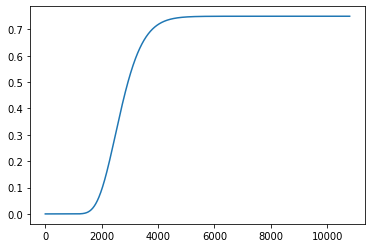

In [73]:
# Retardation with 1st type BC (equation C5)
# 'u' term identical in equation c5 and c6 (type 3 inlet)
# Write out the name of each of these variables
def ADEwR_type1_fun(x, t, v, D, R, gamma, mu, C0, t0, Ci):
    u = v*(1+(4*mu*D/v**2))**(1/2)
    
    # Note that the '\' means continued on the next line
    Atrf = np.exp(-mu*t/R)*(1- (1/2)* \
        erfc((R*x - v*t)/(2*(D*R*t)**(1/2))) - \
        (1/2)*np.exp(v*x/D)*erfc((R*x + v*t)/(2*(D*R*t)**(1/2))))
    
    # term with B(x, t)
    Btrf = 1/2*np.exp((v-u)*x/(2*D))* \
        erfc((R*x - u*t)/(2*(D*R*t)**(1/2))) \
        + 1/2*np.exp((v+u)*x/(2*D))* erfc((R*x + u*t)/ \
        (2*(D*R*t)**(1/2)))
    
    # if a pulse type injection
    if t0 > 0:
        tt0 = t - t0
        
        indices_below_zero = tt0 <= 0
        # set values equal to 1 (but this could be anything)
        tt0[indices_below_zero] = 1
    
        Bttrf = 1/2*np.exp((v-u)*x/(2*D))* \
            erfc((R*x - u*tt0)/(2*(D*R*tt0)**(1/2))) \
            + 1/2*np.exp((v+u)*x/(2*D))* erfc((R*x + u*tt0)/ \
            (2*(D*R*tt0)**(1/2)))
        
        # Now set concentration at those negative times equal to 0
        Bttrf[indices_below_zero] = 0
        
        C_out = (gamma/mu)+ (Ci- gamma/mu)*Atrf + \
            (C0 - gamma/mu)*Btrf - C0*Bttrf
        
    else: # if a continous injection then ignore the Bttrf term (no superposition)
        if mu >0:
            C_out = (gamma/mu)+ (Ci- gamma/mu)*Atrf + (C0 - gamma/mu)*Btrf;
        else: # if mu = 0 then we would get nans
            C_out = (Ci)*Atrf + (C0)*Btrf
        
    
    # Return the concentration (C) from this function
    return C_out

# Now call our function
Retard_pulse_solution = ADEwR_type1_fun(x, t, v, D, R, gamma, mu, C0, t0, Ci)
# Plot the results as a function of time
plt.plot(t, Retard_pulse_solution)

### Analytical solution: Type 1 boundary conditions and continous solute injection with no reactions

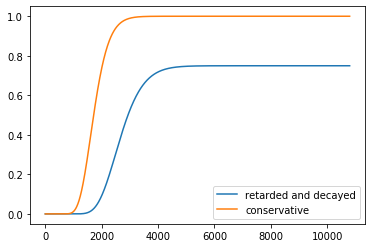

In [77]:
# Analytical solution with built in superposotion
def ADE_type1_real_super_fun(x, t, v, D, C0, t0):
    # Note that the '\' means continued on the next line
    C = C0*((1/2)*erfc((x - v*t)/(2*np.sqrt(D*t))) + \
         (1/2)*np.exp(v*x/D)*erfc((x + v*t)/(2*np.sqrt(D*t))))
    
    # if a pulse type injection
    if t0 > 0:
        tt0 = t - t0
        # Identify location of negative values in time array
        indices_below_zero = tt0 <= 0
        # set values equal to 1 (but this could be anything)
        tt0[indices_below_zero] = 1
        # Note that the '\' means continued on the next line
        C_t0 = C0*((1/2)*erfc((x - v*t0)/(2*np.sqrt(D*t0))) + \
             (1/2)*np.exp(v*x/D)*erfc((x + v*t0)/(2*np.sqrt(D*t0))))
    
        # Now set concentration at those negative times equal to 0
        C_t0[indices_below_zero] = 0
        
        C_out = C - C_t0
        
    else:
            C_out = C
        
    # Return the concentration (C) from this function
    return C_out
    
# Now call our function
Conservative_pulse_solution = ADE_type1_real_super_fun(x, t, v, D, C0, t0)

# Plot the results as a function of time
c1, = plt.plot(t, Retard_pulse_solution, label='retarded and decayed')
c2, = plt.plot(t, Conservative_pulse_solution, label='conservative')

# Format the plots
plt.legend(handles=[c1, c2])

In [75]:
# % Infinite length, type 3 inlet
#     % ADE solution with 1st type BC
#     Atrv = exp(-mu.*t./R).*(1- (1/2).*erfc((R.*x - v.*t)./(2*(D.*R.*t).^(1/2))) - ...
#         (v.^2.*t/(pi*D*R)).^(1/2).*exp(-(R.*x - v.*t).^2./(4.*D.*R.*t)) + ...
#         (1/2).*(1 + v.*x./D + v.^2.*t./(D*R)).*exp(v.*x./D).* ...
#         erfc((R.*x + v.*t)./(2*(D.*R.*t).^(1/2))));
    
#     % term with B(x, t)
#     Btrv = (v./(v+u)).*exp((v-u).*x./(2*D)).* erfc((R.*x - u.*t)./(2.*(D.*R.*t).^(1/2))) + ...
#         (v./(v-u)).*exp((v+u).*x./(2*D)).* erfc((R.*x + u.*t)./(2.*(D.*R.*t).^(1/2))) + ...
#         (v.^2/(2*mu*D)).*exp((v.*x./D) - (mu.*t./R)).* ...
#         erfc((R.*x + v.*t)./(2.*(D.*R.*t).^(1/2)));
    
#     % if continous injection
#     if injection_style == 0
#         if mu >0
#             C_out = (gamma/mu)+ (Ci- gamma/mu).*Atrv + (C0 - gamma/mu).*Btrv;
#         else % if mu = 0 then we would get nans
#             C_out = (Ci).*Atrv + (C0).*Btrv ;
#         end
        
#     % else if pulse injection
#     elseif injection_style == 1
#         % calculate pulse injection length
#         % varargin{1} is equal to t_inj
#         tt0 = t - varargin{1};
        
#         % If you started the 't' array from zero and then subtracted some time
#         % of injection then 'tt0' will have negative numbers. Negative numbers
#         % in the 'erfc' function will lead to errors so to correct for
#         % this I have added the 'real' function inside the 'erfc' functions.
#         % After 'Bttrv' is calculated these imaginary/negative values are set to
#         % zero
#         Bttrv = (v./(v+u)).*exp((v-u).*x./(2*D)).* erfc(real((R.*x - u.*tt0)./(2.*(D.*R.*tt0).^(1/2)))) + ...
#             (v./(v-u)).*exp((v+u).*x./(2*D)).* erfc(real((R.*x + u.*tt0)./(2.*(D.*R.*tt0).^(1/2)))) + ...
#             (v.^2/(2*mu*D)).*exp((v.*x./D) - (mu.*tt0./R)).* ...
#             erfc(real((R.*x + v.*tt0)./(2.*(D.*R.*tt0).^(1/2))));
        
#         % Set imaginary values to 0
#         Bttrv(tt0 <= 0) = 0;
        
#         % calculation concentration via superposition
#         C_out = (gamma/mu)+ (Ci- gamma/mu).*Atrv + (C0 - gamma/mu).*Btrv - C0.*Bttrv;
#     end

Note that the input and system geometry is identical except for the boundary conditions!

## Activity:
Using these functions, evaluate the how the shape of the curves depends on the dispersion. Describe and discuss what you see. If two cores have identical geometry and flow rate conditions but different dispersion behavior, what does this mean? 

Next, use the principle of superposition to analytically describe a finite pulse of solute, as opposed to the continuous injection currently being modeled. See van Genuchten and Alves 1982 for formal descriptions and additional solutions.